In [6]:
# import necessary modules
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle 
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks_cwt


pi = 3.14159
# Define size for sliding windows
window_size = 60

# load calibration data from pickled file
data = pickle.load( open( "camera_calibration.pkl", "rb" ) )
mtx_camera = data[0]
dist_camera = data[1]

%matplotlib inline

(-0.5, 1279.5, 719.5, -0.5)

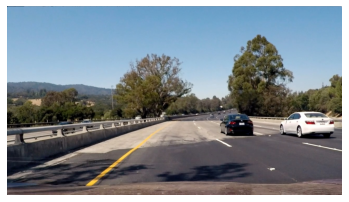

In [7]:
#read an image
image = mpimg.imread('test_images/test4.jpg')
# plot the image using matplot 
plt.imshow(image) 
plt.axis('off')

In [8]:
def undistort_image(img, mtx, dist):
    """ function to undistort image using camera Matrix and distortion coeffcients from camera calibration  """
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img

def gaussian_blur(img, kernel=5):
    """ gaussian blur """
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

def warp_image(img,src,dst,img_size):
    """ using cv2 function to apply perspective transform and get bird eye view"""
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped,M,Minv

def apply_perspective_transform(image):
    """ Applies bird-eye perspective transform to an image """
    img_size = image.shape
    ht_window = np.uint(img_size[0]/1.5)
    hb_window = np.uint(img_size[0])
    c_window = np.uint(img_size[1]/2)
    ctl_window = c_window - .25*np.uint(img_size[1]/2)
    ctr_window = c_window + .25*np.uint(img_size[1]/2)
    cbl_window = c_window - 1*np.uint(img_size[1]/2)
    cbr_window = c_window + 1*np.uint(img_size[1]/2)
    src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],
                      [ctr_window,ht_window],[ctl_window,ht_window]])
    dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],
                  [img_size[1],0],[0,0]])
    
    warped,M_warp,Minv_warp = warp_image(image,src,dst,(img_size[1],img_size[0])) # returns birds eye image
    return warped,M_warp,Minv_warp

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if orient=='x':
        img_s = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))
    
    binary_output = 0*img_sobel
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 1
    return binary_output

# Calculate gradient magnitude of sobel filter with threasold ranges between 0:255
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    img_sx = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    img_sy = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    
    img_s = np.sqrt(img_sx**2 + img_sy**2)
    img_s = np.uint8(img_s*255/np.max(img_s))
    binary_output = 0*img_s
    binary_output[(img_s>=thresh[0]) & (img_s<=thresh[1]) ]=1
    return binary_output

# Calculate gradient direction of sobel filter with threasold ranges between 0:pi/2
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    img_sx = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=sobel_kernel)
    img_sy = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=sobel_kernel)
    
    grad_s = np.arctan2(np.absolute(img_sy), np.absolute(img_sx))
    
    binary_output = 0*grad_s # Remove this line
    binary_output[(grad_s>=thresh[0]) & (grad_s<=thresh[1])] = 1
    return binary_output

def sobel_combined(image):
    # Combine sobel masks.
    img_g_mag = mag_thresh(image,3,(20,150))
    img_d_mag = dir_threshold(image,3,(.6,1.1))
    img_abs_x = abs_sobel_thresh(image,'x',5,(50,200))
    img_abs_y = abs_sobel_thresh(image,'y',5,(50,200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
               ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return sobel_combined

def color_mask(hsv,low,high):
    # Takes in low and high values and returns mask
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv,img,low,high):
    # Takes in color mask and returns image with mask applied.
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res


def get_mask_poly(img,poly_fit,window_sz):
    """
        This function returns masks for points used in computing polynomial fit. 
    """
    mask_poly = np.zeros_like(img)
    img_size = np.shape(img)

    poly_pts = []
    pt_y_all = []

    for i in range(8):
        img_y1 = int(img_size[0]-img_size[0]*i/8) # take a slice from the image
        img_y2 =int(img_size[0]-img_size[0]*(i+1)/8)

        pt_y = (img_y1+img_y2)/2
        pt_y_all.append(pt_y)
        poly_pt = np.round(poly_fit[0]*pt_y**2 + poly_fit[1]*pt_y + poly_fit[2])
    
        poly_pts.append(poly_pt)
    
        mask_poly[img_y2:img_y1,int(poly_pt-window_sz):int(poly_pt+window_sz)] = 1.0

    return mask_poly, np.array(poly_pts),np.array(pt_y_all)
def cumulative_sum(a, n=3):
    """get cumulative sum"""
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
        
def get_initial_mask(img,window_sz):
    """
    This function gets the mask of the lane where it gets the left and the right lanes
    seperatly and if any lane is not continuous it completes it to draw a continuous line
    and if no peak(Lane) found it returns the prev one
    """
    
    
    img = gaussian_blur(img,5)
    img_size = np.shape(img)
    mov_filtsize = int(img_size[1]/50.)
    mean_ln = np.mean(img[int(img_size[0]/2):,:],axis=0)
    mean_ln = cumulative_sum(mean_ln,mov_filtsize)
    # get the value of x axis of the two peaks
    indexes = find_peaks_cwt(mean_ln,[100], max_distances=[800])

    val_ind = np.array([mean_ln[indexes[i]] for i in range(len(indexes)) ])
    #* get the index of sorted elements 
    ind_sorted = np.argsort(-val_ind)

    ind_peakR = indexes[ind_sorted[0]]
    ind_peakL = indexes[ind_sorted[1]]
    if ind_peakR<ind_peakL:
        ind_temp = ind_peakR
        ind_peakR = ind_peakL
        ind_peakL = ind_temp


    mask_L_i = np.zeros_like(img)
    mask_R_i = np.zeros_like(img)

    ind_peakR_prev = ind_peakR
    ind_peakL_prev = ind_peakL
    
    # Split image into 8 parts and compute histogram on each part
    
    for i in range(8):
        img_y1 = int(img_size[0]-img_size[0]*i/8)
        img_y2 = int(img_size[0]-img_size[0]*(i+1)/8)
    
        mean_lane_y = np.mean(img[img_y2:img_y1,:],axis=0)
        mean_lane_y = cumulative_sum(mean_lane_y,mov_filtsize)
        indexes = find_peaks_cwt(mean_lane_y,[100], max_distances=[800])
        
        if len(indexes)>1.5:
            val_ind = np.array([mean_ln[indexes[i]] for i in range(len(indexes)) ])
            ind_sorted = np.argsort(-val_ind)

            ind_peakR = indexes[ind_sorted[0]]
            ind_peakL = indexes[ind_sorted[1]]
            if ind_peakR<ind_peakL:
                ind_temp = ind_peakR
                ind_peakR = ind_peakL
                ind_peakL = ind_temp
            
        else:
        # If no pixels are found, use previous ones. 
            if len(indexes)==1:
                if (np.abs(indexes[0]-ind_peakR_prev)<np.abs(indexes[0]-ind_peakL_prev)):
                    ind_peakR = indexes[0]
                    ind_peakL = ind_peakL_prev
                else:
                    ind_peakL = indexes[0]
                    ind_peakR = ind_peakR_prev
            else:
                ind_peakL = ind_peakL_prev
                ind_peakR = ind_peakR_prev
            
            
        # If new center is more than 60pixels away, use previous
        # Outlier rejection
        if np.abs(ind_peakL-ind_peakL_prev)>=60:
            ind_peakL = ind_peakL_prev

        if np.abs(ind_peakR-ind_peakR_prev)>=60:
            ind_peakR = ind_peakR_prev
            
    
            
        mask_L_i[img_y2:img_y1,int(ind_peakL-window_sz):int(ind_peakL+window_sz)] = 1.0
        mask_R_i[img_y2:img_y1,int(ind_peakR-window_sz):int(ind_peakR+window_sz)] = 1.0
        
        ind_peakL_prev = ind_peakL
        ind_peakR_prev = ind_peakR
        
    return mask_L_i,mask_R_i


In [9]:
def get_val(y,pol_a):
    # Returns value of a quadratic polynomial 
    return pol_a[0]*y**2+pol_a[1]*y+pol_a[2]

def draw_pw_lines(img,pts,color):
    # This function draws lines connecting 10 points along the polynomial
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(img, (x1, y1), (x2, y2),color,50)
        
def get_curvature(pol_a,y_pt):
    # Returns curvature of a quadratic
    A = pol_a[0]
    B = pol_a[1]
    R_curve = (1+(2*A*y_pt+B)**2)**1.5/2/A
    return R_curve

def stack_arr(arr):
    # Stacks 1-channel array into 3-channel array to allow plotting
    return np.stack((arr, arr,arr), axis=2)


In [10]:
left_bot=0
right_bot = 0
def pipeline_process_highway(image):
    
    global left_fit_prev   
    global right_fit_prev
    global col_R_prev
    global col_L_prev
    global set_prev
    global mask_poly_L
    global mask_poly_R
    global left_bot
    global right_bot
    # Undistort image
    image = undistort_image(image, mtx_camera , dist_camera )

    # smooth the image
    image = gaussian_blur(image, kernel=5)

    # image size
    img_size = np.shape(image)
    
    # get bird eye view
    warped,M_warp,Minv_warp = apply_perspective_transform(image)

    
    image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)
    # Define color ranges and apply color mask
    yellow_hsv_low  = np.array([ 0, 100, 100])
    yellow_hsv_high = np.array([ 50, 255, 255])

    white_hsv_low  = np.array([  20,   0,   180])
    white_hsv_high = np.array([ 255,  80, 255])
    # get yellow and white masks 
    mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
    # Combine white and yellow masks into 1
    mask_lane = cv2.bitwise_or(mask_yellow,mask_white) 
    
    # Convert image to HLS scheme
    image_HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)

    # Apply sobel filters on L and S channels.
    img_gs = image_HLS[:,:,1]
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,225))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,225))
    wraped2 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    img_gs = image_HLS[:,:,2]
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,255))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,255))
    wraped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    

    # Combine sobel filter information from L and S channels.
    image_cmb = cv2.bitwise_or(wraped2,wraped3)
    image_cmb = gaussian_blur(image_cmb,25)
    

    # Combine masks from sobel and color masks.

    image_cmb1 = np.zeros_like(image_cmb)
    image_cmb1[(mask_lane>=.5)|(image_cmb>=.5)]=1



    # If this is first frame, get new mask.
    if set_prev == 0:
        image_cmb1 = gaussian_blur(image_cmb1,5)
        mask_poly_L,mask_poly_R = get_initial_mask(image_cmb1,40)

        
        
    # Define all colors as white to start.         
    col_R = (255,255,255)
    col_L = (255,255,255)
    col_R = (255,255,255)
    col_L = (255,255,255)
    
    # Apply mask to sobel images and compute polynomial fit for left. 
    img_L = np.copy(image_cmb1)
    img_L = cv2.bitwise_and(image_cmb1,image_cmb1,
                                mask = mask_poly_L)
    vals = np.argwhere(img_L>.5)
    if len(vals)<5: ## If less than 5 points 
        left_fit = left_fit_prev
        col_L = col_L_prev
    else:
        all_x = vals.T[0]
        all_y =vals.T[1]
        left_fit = np.polyfit(all_x, all_y, 2)
        if np.sum(cv2.bitwise_and(img_L,mask_yellow))>1000:
            col_L = (255,255,0)
            
    # Apply mask to sobel images and compute polynomial fit for right. 

    img_R = np.copy(image_cmb1)
    img_R = cv2.bitwise_and(image_cmb1,image_cmb1,
                                mask = mask_poly_R)
    vals = np.argwhere(img_R>.5)
        
    if len(vals)<5:
        right_fit = right_fit_prev
        col_R = col_R_prev
    else:
        all_x = vals.T[0]
        all_y =vals.T[1]
        right_fit = np.polyfit(all_x, all_y, 2)
        if np.sum(cv2.bitwise_and(img_R,mask_yellow))>1000:
            col_R = (255,255,0)
    
    
    ## assign initial mask, and save coefficient values for next frame
            
    if set_prev == 0:
        set_prev = 1
        right_fit_prev = right_fit
        left_fit_prev  = left_fit
    
       
    ## Check error between current coefficient and on from previous frame
    err_p_R = np.sum((right_fit[0]-right_fit_prev[0])**2) #/np.sum(right_fit_prev[0]**2)
    err_p_R = np.sqrt(err_p_R)
    if err_p_R>.0005:
        right_fit = right_fit_prev
        col_R = col_R_prev
    else:
        right_fit = .05*right_fit+.95*right_fit_prev
        
    ## Check error between current coefficient and on from previous frame
    err_p_L = np.sum((left_fit[0]-left_fit_prev[0])**2) #/np.sum(right_fit_prev[0]**2)
    err_p_L = np.sqrt(err_p_L)
    if err_p_L>.0005:
        left_fit =  left_fit_prev
        col_L = col_L_prev
    else:
        left_fit =  .05* left_fit+.95* left_fit_prev
## Compute lane mask for future frame 
    mask_poly_L,left_pts,img_pts = get_mask_poly(image_cmb1,left_fit,window_size)
    mask_poly_R,right_pts,img_pts = get_mask_poly(image_cmb1,right_fit,window_size)
     
        
    ## Compute lanes
        
    right_y = np.arange(11)*img_size[0]/10
    right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]

    left_y = np.arange(11)*img_size[0]/10
    left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]
    
    warp_zero = np.zeros_like(image_cmb1).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
    pts = np.hstack((pts_left, pts_right))
    
    

    ## Compute intercepts
    left_bot = get_val(img_size[0],left_fit)
    #print("left_bot", left_bot)
    right_bot = get_val(img_size[0],right_fit)
    #print("right_bot", right_bot)
    
    ## Compute center location
    val_center = (left_bot+right_bot)/2.0
    #print("val_center", val_center)
    
    ## Compute lane offset
    dist_offset = val_center - img_size[1]/2
    #print("img_size[1]/2", img_size[1]/2)
    #print("dist_offset", dist_offset)
    px_to_meter = 3.7/700
    dist_offset = np.round(dist_offset*px_to_meter,2)

    #print("dist_offset", dist_offset)
    str_offset = 'Lane deviation: ' + str(dist_offset) + ' m.'
    
    if dist_offset>0.4:
        cv2.fillPoly(color_warp, np.int_([pts]), (255,0, 0))
    else:
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        

    # Draw the lane onto the warped blank image    
    draw_pw_lines(color_warp,np.int_(pts_left),col_L)
    draw_pw_lines(color_warp,np.int_(pts_right),col_R)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    
    newwarp = cv2.warpPerspective(color_warp, Minv_warp, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)
    
    left_curve = get_curvature(left_fit,img_size[0]/2)
    Right_curve = get_curvature(right_fit,img_size[0]/2)
    center_curve = (left_curve+ Right_curve) / 2
    str_curv = 'Curvature: Right = ' + str(np.round(Right_curve,2)) + ', Left = ' + str(np.round(left_curve,2)) 
    center_curv = "Radius of curvature = "  + str(np.round(center_curve,2)) + " m"
    # Change color if distance is more than 40 cm
    font = cv2.FONT_HERSHEY_COMPLEX    
    if dist_offset<0.4:
        cv2.putText(result, str_curv, (30, 60), font, 1, (0,255,0), 2)
        cv2.putText(result, center_curv, (30, 90), font, 1, (0,255,0), 2)
        cv2.putText(result, str_offset, (30, 120), font, 1, (0,255,0), 2)
        
    else:
        cv2.putText(result, str_curv, (30, 60), font, 1, (255,0,0), 2)
        cv2.putText(result, center_curv, (30, 90), font, 1, (255,0,0), 2)
        cv2.putText(result, str_offset, (30, 120), font, 1, (255,0,0), 2)
    
    
    
    right_fit_prev = right_fit
    left_fit_prev  = left_fit
    col_R_prev = col_R
    col_L_prev = col_L
    
    
    #return result    # using cv2 for drawing text in diagnostic pipeline.
    
    if do_diagnosis == 1:
        font = cv2.FONT_HERSHEY_COMPLEX
        middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)
        cv2.putText(middlepanel, str_curv, (30, 60), font, 1, (255,0,0), 2)
        cv2.putText(middlepanel, center_curv, (30, 90), font, 1, (255,0,0), 2)
        cv2.putText(middlepanel, str_offset, (30, 120), font, 1, (255,0,0), 2)
        
        warped_cpy = warped.copy()
        cv2.putText(warped, "Eagle eye", (30, 90), font, 3, (255,0,255), 2)
        
        cv2.putText(mask_lane, "Mask lane", (30, 90), font, 3, (255,255,255), 2)
        #cv2.putText(image_HSV, "Left lane", (30, 60), font, 5, (160,0,73), 2)
        cv2.putText(color_warp, "Color lane transformed", (30, 60), font,1.5, (255,0,255), 2)
        cv2.putText(newwarp, "Color lane", (30, 60), font, 2.5, (255,0,255), 2)
        cmb_cpy = image_cmb1.copy()
        cv2.putText(image_cmb1, "Sobel and color masks", (30, 60), font, 2, (100,150,150), 2)
        
        cv2.putText(mask_poly_L, "Mask polynomial", (30, 60), font, 2, (100,150,150), 2)
        yellow_lane = apply_color_mask(image_HSV,warped_cpy,yellow_hsv_low,yellow_hsv_high)
        cv2.putText(yellow_lane, "Left Lane", (30, 90), font, 3, (255,0,255), 2)
        white_lane = apply_color_mask(image_HSV,warped_cpy,white_hsv_low,white_hsv_high)
        cv2.putText(white_lane, "Right Lane", (30, 90), font, 3, (255,0,255), 2)
        # assemble the screen example
        diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
        diagScreen[0:720, 0:1280] = result
        diagScreen[0:240, 1280:1600] = cv2.resize(warped, (320,240), interpolation=cv2.INTER_AREA) 
        diagScreen[0:240, 1600:1920] = cv2.resize(stack_arr(mask_lane), (320,240), interpolation=cv2.INTER_AREA)
        
        diagScreen[240:480, 1280:1600] = cv2.resize(yellow_lane, (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[240:480, 1600:1920] = cv2.resize(white_lane, (320,240), interpolation=cv2.INTER_AREA)*4
        diagScreen[600:1080, 1280:1920] = cv2.resize(color_warp, (640,480), interpolation=cv2.INTER_AREA)*4
        diagScreen[720:840, 0:1280] = middlepanel
        diagScreen[840:1080, 0:320] = cv2.resize(newwarp, (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[840:1080, 320:640] = cv2.resize(stack_arr(255*mask_poly_L), (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[840:1080, 640:960] = cv2.resize(stack_arr(255*mask_poly_R), (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[840:1080, 960:1280] = cv2.resize(stack_arr(255*image_cmb1), (320,240), interpolation=cv2.INTER_AREA)
    
        diagScreen[840:1080, 520:840] = cv2.resize(stack_arr(255*image_cmb1), (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[840:1080, 960:1280] = cv2.resize(stack_arr(255*mask_poly_L+255*mask_poly_R), (320,240), interpolation=cv2.INTER_AREA)
        """ diagScreen[840:1080, 960:1280] = cv2.resize(stack_arr(255*cv2.bitwise_and(cmb_cpy,cmb_cpy,
                                                                              mask=mask_poly_L+mask_poly_R)),
                                                (320,240), interpolation=cv2.INTER_AREA) """
        return diagScreen
    else:
        return result

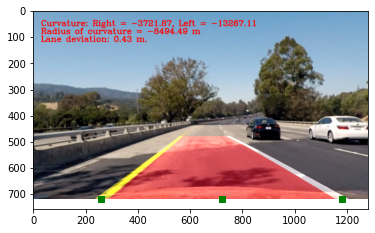

In [11]:
do_diagnosis = 0
set_prev = 0

result_pipe = pipeline_process_highway(image)
plt.imshow(result_pipe)
plt.plot(left_bot,720,'gs')
plt.plot(right_bot,720,'gs')
plt.plot((left_bot+right_bot)/2.0,720,'gs')

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
set_prev = 0
do_diagnosis = 0

challenge_output = 'challenge_video_output.mp4'
clip2 = VideoFileClip("challenge_video.mp4");
white_clip = clip2.fl_image(pipeline_process_highway) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_output, audio=False);

Moviepy - Building video challenge_video_output.mp4.
Moviepy - Writing video challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready challenge_video_output.mp4
CPU times: total: 6min 27s
Wall time: 1min 39s


In [14]:
set_prev = 0
do_diagnosis = 0

project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4");
white_clip = clip1.fl_image(pipeline_process_highway) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False);
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: total: 16min 55s
Wall time: 4min 5s


In [15]:
#left_fit_prev = np.array([0,0,0])
#right_fit_prev = np.array([0,0,0])
set_prev = 0
do_diagnosis = 1

project_output_diag = 'project_video_output_diag.mp4'
clip3 = VideoFileClip("project_video.mp4");
white_clip = clip3.fl_image(pipeline_process_highway) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output_diag, audio=False);

Moviepy - Building video project_video_output_diag.mp4.
Moviepy - Writing video project_video_output_diag.mp4



Moviepy - Done !
Moviepy - video ready project_video_output_diag.mp4
CPU times: total: 18min 58s
Wall time: 5min 34s


In [16]:
set_prev = 0
do_diagnosis = 1

challenge_output_diag = 'trim_video_output_diag-test.mp4'
clip4 = VideoFileClip("project_video_trim.mp4");
white_clip = clip4.fl_image(pipeline_process_highway) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_output_diag, audio=False);
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output_diag))

OSError: MoviePy error: the file project_video_trim.mp4 could not be found!
Please check that you entered the correct path.